<a href="https://colab.research.google.com/github/cauc1ronman/Xin-Dong/blob/master/ECG_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training

model

In [1]:
#! /usr/bin/enc python
# -*- coding: utf-8 -*-
# author: Jarvis Dong
# email: cauc1ronman@outlook.com

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Fine-tuneable
# def replace_head(model, num_classes):
#     model[-1][-1] = nn.Linear(512, num_classes)
#     apply_init(model[1], nn.init.kaiming_normal_)

# conv1xk (3x3,stride=1)
def conv1xk(in_channels,out_channels,kernel_size=3,stride=1):
    padding = kernel_size//2
    return nn.Conv1d(in_channels,out_channels,kernel_size=kernel_size,
                        stride=stride,padding=padding,bias=False)

# initialization
def init_cnn_1d(m):
    if getattr(m, 'bias', None) is not None:
        nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv1d,nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn_1d(l)

# def  splitter(m):
#     return L(m[0][:6], m[0][6:], m[1]).map(params)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv1xk(in_channels, out_channels, kernel_size, stride)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv1xk(out_channels, out_channels, kernel_size)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(residual)
        out += residual
        out = self.relu(out)
        return out

# Resnet1D
class ResNet_ecg(nn.Sequential):
    def __init__(self,block,layers,in_channels=64,num_classes=10,kernel_size=3,stride=2,dropout=0.2):
        """

        :param block:
        :param layers:
        :param in_channels:
        :param num_classes:
        :param kernel_size:
        :param stride:
        :param dropout:
        """
        in_block = [] # input_block
        residual_block = [] # residual blocks
        header_block = [] # linear head

        self.in_channels = in_channels
        self.block = block

        in_kernel_size = kernel_size*2 + 1

        in_block.append(conv1xk(1, in_channels, in_kernel_size, stride))
        in_block.append(nn.BatchNorm1d(in_channels))
        in_block.append(nn.ReLU(inplace=True))
        in_block.append(nn.MaxPool1d(kernel_size, stride, kernel_size//3))

        residual_block = self.make_blocks(layers, in_channels, kernel_size, stride)

        header_block.append(nn.AdaptiveAvgPool1d(1))
        header_block.append(nn.Flatten())
        # header_block.append(nn.Dropout(dropout))
        # header_block.append(nn.Linear(in_channels*2**(len(layers)-1), num_classes))
        header_block.append(nn.Linear(in_channels*2**(len(layers)-1), 128))
        header_block.append(nn.BatchNorm1d(128))
        header_block.append(nn.ReLU(inplace=True))
        # header_block.append(nn.Dropout(dropout))
        # header_block.append(nn.Linear(2048,512))
        # header_block.append(nn.BatchNorm1d(512))
        # header_block.append(nn.ReLU(inplace=True))
        # header_block.append(nn.Linear(512,512))
        # header_block.append(nn.ReLU(inplace=True))
        header_block.append(nn.Linear(128,num_classes))

        super().__init__(nn.Sequential(*in_block,*residual_block),nn.Sequential(*header_block))
        init_cnn_1d(self)

    def make_blocks(self, layers, in_channels, kernel_size, stride):
        return [self.make_layer(self.block, in_channels*2**i, l, kernel_size, stride) for i, l in enumerate(layers)]

    def make_layer(self, block, out_channels, blocks, kernel_size=3, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv1xk (self.in_channels, out_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm1d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, kernel_size, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels, kernel_size))
        return nn.Sequential(*layers)

Training

In [2]:
#! /usr/bin/enc python
# -*- coding: utf-8 -*-
# author: Jarvis Dong
# email: cauc1ronman@outlook.com

from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import accuracy_score 
import inspect 

from torch.optim.lr_scheduler import _LRScheduler 

def calculate_metric(metric_fn, true_y, pred_y):
  # multi class problems need to have averaging method
  if "average" in inspect.getfullargspec(metric_fn).args:
    return metric_fn(true_y, pred_y, average="macro")
  else:
    return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
  # just an utility printing function
  for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
    print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

class WarmUpLR(_LRScheduler):
  """warmup_training learning rate scheduler
  Args:
      optimizer: optimzier(e.g. SGD)
      total_iters: totoal_iters of warmup phase
  """
  def __init__(self, optimizer, total_iters, last_epoch=-1):
    self.total_iters = total_iters
    super().__init__(optimizer, last_epoch)

  def get_lr(self):
    """we will use the first m batches, and set the learning
    rate to base_lr * m / total_iters
    """
    return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]

In [3]:
#! /usr/bin/enc python
# -*- coding: utf-8 -*-
# author: Jarvis Dong
# email: cauc1ronman@outlook.com

import numpy as np
import torch
import sys
# from Model.ResNet18_34.Model import *

from torch.utils.data import DataLoader
from tqdm import tqdm
from torchsummary import summary
import time

import torch 
# 清除GPU内存 
torch.cuda.empty_cache()

# sys.path.append("Model") # 改用torchvision的改写版的resnet1d 
# torch.cuda.empty_cache() # clean the cache of gpu

device_str = "cuda"
device = torch.device(device_str if torch.cuda.is_available() else "cpu")
print("current device",device)

RES1D18 = {
    "block":ResidualBlock,
    "layers":[2,2,2,2],
    "in_channels":128,
    "kernel_size":15,
    "stride":4,
    "num_classes":5 # order 0 to 4
}

RES1D34 = {
    "block": ResidualBlock,
    "layers": [3, 4, 6, 3],
    "in_channels": 64,
    "kernel_size": 15,
    "stride": 4,
    "num_classes": 5 #order 0 to 4
}

# # signal params 
# Fs = 2048
# times = np.arange(0,1,1/Fs)

# batch_size = 32 
# batch_size = 64
batch_size = 64 
num_workers = 0 

num_epochs = 500
step = 0 

config = RES1D18 
# config = RES1D34
config['num_classes']= 5

save_every_epoch = 10
test_every_epoch = 1  

current device cuda


# spoto

In [4]:
# -*- coding: utf-8 -*-
# Generated by the protocol buffer compiler.  DO NOT EDIT!
# source: tensor.proto

from google.protobuf import descriptor as _descriptor
from google.protobuf import message as _message
from google.protobuf import reflection as _reflection
from google.protobuf import symbol_database as _symbol_database
# @@protoc_insertion_point(imports)

_sym_db = _symbol_database.Default()




DESCRIPTOR = _descriptor.FileDescriptor(
  name='tensor.proto',
  package='',
  syntax='proto3',
  serialized_options=None,
  create_key=_descriptor._internal_create_key,
  serialized_pb=b'\n\x0ctensor.proto\",\n\x0cTensorProtos\x12\x1c\n\x06protos\x18\x01 \x03(\x0b\x32\x0c.TensorProto\"\xe0\x02\n\x0bTensorProto\x12\x0c\n\x04\x64ims\x18\x01 \x03(\x03\x12(\n\tdata_type\x18\x02 \x01(\x0e\x32\x15.TensorProto.DataType\x12\x12\n\nfloat_data\x18\x03 \x03(\x02\x12\x12\n\nint32_data\x18\x04 \x03(\x05\x12\x11\n\tbyte_data\x18\x05 \x01(\x0c\x12\x13\n\x0bstring_data\x18\x06 \x03(\x0c\x12\x13\n\x0b\x64ouble_data\x18\x07 \x03(\x01\x12\x12\n\nint64_data\x18\x08 \x03(\x03\"\x9f\x01\n\x08\x44\x61taType\x12\r\n\tUNDEFINED\x10\x00\x12\t\n\x05\x46LOAT\x10\x01\x12\t\n\x05INT32\x10\x02\x12\x08\n\x04\x42YTE\x10\x03\x12\n\n\x06STRING\x10\x04\x12\x08\n\x04\x42OOL\x10\x05\x12\t\n\x05UINT8\x10\x06\x12\x08\n\x04INT8\x10\x07\x12\n\n\x06UINT16\x10\x08\x12\t\n\x05INT16\x10\t\x12\t\n\x05INT64\x10\n\x12\x0b\n\x07\x46LOAT16\x10\x0c\x12\n\n\x06\x44OUBLE\x10\rb\x06proto3'
)



_TENSORPROTO_DATATYPE = _descriptor.EnumDescriptor(
  name='DataType',
  full_name='TensorProto.DataType',
  filename=None,
  file=DESCRIPTOR,
  create_key=_descriptor._internal_create_key,
  values=[
    _descriptor.EnumValueDescriptor(
      name='UNDEFINED', index=0, number=0,
      serialized_options=None,
      type=None,
      create_key=_descriptor._internal_create_key),
    _descriptor.EnumValueDescriptor(
      name='FLOAT', index=1, number=1,
      serialized_options=None,
      type=None,
      create_key=_descriptor._internal_create_key),
    _descriptor.EnumValueDescriptor(
      name='INT32', index=2, number=2,
      serialized_options=None,
      type=None,
      create_key=_descriptor._internal_create_key),
    _descriptor.EnumValueDescriptor(
      name='BYTE', index=3, number=3,
      serialized_options=None,
      type=None,
      create_key=_descriptor._internal_create_key),
    _descriptor.EnumValueDescriptor(
      name='STRING', index=4, number=4,
      serialized_options=None,
      type=None,
      create_key=_descriptor._internal_create_key),
    _descriptor.EnumValueDescriptor(
      name='BOOL', index=5, number=5,
      serialized_options=None,
      type=None,
      create_key=_descriptor._internal_create_key),
    _descriptor.EnumValueDescriptor(
      name='UINT8', index=6, number=6,
      serialized_options=None,
      type=None,
      create_key=_descriptor._internal_create_key),
    _descriptor.EnumValueDescriptor(
      name='INT8', index=7, number=7,
      serialized_options=None,
      type=None,
      create_key=_descriptor._internal_create_key),
    _descriptor.EnumValueDescriptor(
      name='UINT16', index=8, number=8,
      serialized_options=None,
      type=None,
      create_key=_descriptor._internal_create_key),
    _descriptor.EnumValueDescriptor(
      name='INT16', index=9, number=9,
      serialized_options=None,
      type=None,
      create_key=_descriptor._internal_create_key),
    _descriptor.EnumValueDescriptor(
      name='INT64', index=10, number=10,
      serialized_options=None,
      type=None,
      create_key=_descriptor._internal_create_key),
    _descriptor.EnumValueDescriptor(
      name='FLOAT16', index=11, number=12,
      serialized_options=None,
      type=None,
      create_key=_descriptor._internal_create_key),
    _descriptor.EnumValueDescriptor(
      name='DOUBLE', index=12, number=13,
      serialized_options=None,
      type=None,
      create_key=_descriptor._internal_create_key),
  ],
  containing_type=None,
  serialized_options=None,
  serialized_start=256,
  serialized_end=415,
)
_sym_db.RegisterEnumDescriptor(_TENSORPROTO_DATATYPE)


_TENSORPROTOS = _descriptor.Descriptor(
  name='TensorProtos',
  full_name='TensorProtos',
  filename=None,
  file=DESCRIPTOR,
  containing_type=None,
  create_key=_descriptor._internal_create_key,
  fields=[
    _descriptor.FieldDescriptor(
      name='protos', full_name='TensorProtos.protos', index=0,
      number=1, type=11, cpp_type=10, label=3,
      has_default_value=False, default_value=[],
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      serialized_options=None, file=DESCRIPTOR,  create_key=_descriptor._internal_create_key),
  ],
  extensions=[
  ],
  nested_types=[],
  enum_types=[
  ],
  serialized_options=None,
  is_extendable=False,
  syntax='proto3',
  extension_ranges=[],
  oneofs=[
  ],
  serialized_start=16,
  serialized_end=60,
)


_TENSORPROTO = _descriptor.Descriptor(
  name='TensorProto',
  full_name='TensorProto',
  filename=None,
  file=DESCRIPTOR,
  containing_type=None,
  create_key=_descriptor._internal_create_key,
  fields=[
    _descriptor.FieldDescriptor(
      name='dims', full_name='TensorProto.dims', index=0,
      number=1, type=3, cpp_type=2, label=3,
      has_default_value=False, default_value=[],
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      serialized_options=None, file=DESCRIPTOR,  create_key=_descriptor._internal_create_key),
    _descriptor.FieldDescriptor(
      name='data_type', full_name='TensorProto.data_type', index=1,
      number=2, type=14, cpp_type=8, label=1,
      has_default_value=False, default_value=0,
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      serialized_options=None, file=DESCRIPTOR,  create_key=_descriptor._internal_create_key),
    _descriptor.FieldDescriptor(
      name='float_data', full_name='TensorProto.float_data', index=2,
      number=3, type=2, cpp_type=6, label=3,
      has_default_value=False, default_value=[],
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      serialized_options=None, file=DESCRIPTOR,  create_key=_descriptor._internal_create_key),
    _descriptor.FieldDescriptor(
      name='int32_data', full_name='TensorProto.int32_data', index=3,
      number=4, type=5, cpp_type=1, label=3,
      has_default_value=False, default_value=[],
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      serialized_options=None, file=DESCRIPTOR,  create_key=_descriptor._internal_create_key),
    _descriptor.FieldDescriptor(
      name='byte_data', full_name='TensorProto.byte_data', index=4,
      number=5, type=12, cpp_type=9, label=1,
      has_default_value=False, default_value=b"",
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      serialized_options=None, file=DESCRIPTOR,  create_key=_descriptor._internal_create_key),
    _descriptor.FieldDescriptor(
      name='string_data', full_name='TensorProto.string_data', index=5,
      number=6, type=12, cpp_type=9, label=3,
      has_default_value=False, default_value=[],
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      serialized_options=None, file=DESCRIPTOR,  create_key=_descriptor._internal_create_key),
    _descriptor.FieldDescriptor(
      name='double_data', full_name='TensorProto.double_data', index=6,
      number=7, type=1, cpp_type=5, label=3,
      has_default_value=False, default_value=[],
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      serialized_options=None, file=DESCRIPTOR,  create_key=_descriptor._internal_create_key),
    _descriptor.FieldDescriptor(
      name='int64_data', full_name='TensorProto.int64_data', index=7,
      number=8, type=3, cpp_type=2, label=3,
      has_default_value=False, default_value=[],
      message_type=None, enum_type=None, containing_type=None,
      is_extension=False, extension_scope=None,
      serialized_options=None, file=DESCRIPTOR,  create_key=_descriptor._internal_create_key),
  ],
  extensions=[
  ],
  nested_types=[],
  enum_types=[
    _TENSORPROTO_DATATYPE,
  ],
  serialized_options=None,
  is_extendable=False,
  syntax='proto3',
  extension_ranges=[],
  oneofs=[
  ],
  serialized_start=63,
  serialized_end=415,
)

_TENSORPROTOS.fields_by_name['protos'].message_type = _TENSORPROTO
_TENSORPROTO.fields_by_name['data_type'].enum_type = _TENSORPROTO_DATATYPE
_TENSORPROTO_DATATYPE.containing_type = _TENSORPROTO
DESCRIPTOR.message_types_by_name['TensorProtos'] = _TENSORPROTOS
DESCRIPTOR.message_types_by_name['TensorProto'] = _TENSORPROTO
_sym_db.RegisterFileDescriptor(DESCRIPTOR)

TensorProtos = _reflection.GeneratedProtocolMessageType('TensorProtos', (_message.Message,), {
  'DESCRIPTOR' : _TENSORPROTOS,
  '__module__' : 'tensor_pb2'
  # @@protoc_insertion_point(class_scope:TensorProtos)
  })
_sym_db.RegisterMessage(TensorProtos)

TensorProto = _reflection.GeneratedProtocolMessageType('TensorProto', (_message.Message,), {
  'DESCRIPTOR' : _TENSORPROTO,
  '__module__' : 'tensor_pb2'
  # @@protoc_insertion_point(class_scope:TensorProto)
  })
_sym_db.RegisterMessage(TensorProto)


# @@protoc_insertion_point(module_scope)

tensor_pb2.TensorProto

In [5]:

# Copyright 2019 ASLP@NPU.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#
# Author: npuichigo@gmail.com (zhangyuchao)

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np




def tensor_to_numpy_array(tensor):
    if tensor.data_type == TensorProto.FLOAT:
        return np.asarray(
            tensor.float_data, dtype=np.float32).reshape(tensor.dims)
    elif tensor.data_type == TensorProto.DOUBLE:
        return np.asarray(
            tensor.double_data, dtype=np.float64).reshape(tensor.dims)
    elif tensor.data_type == TensorProto.INT32:
        return np.asarray(
            tensor.int32_data, dtype=np.int).reshape(tensor.dims)  # pb.INT32=>np.int use int32_data
    elif tensor.data_type == TensorProto.INT16:
        return np.asarray(
            tensor.int32_data, dtype=np.int16).reshape(tensor.dims)  # pb.INT16=>np.int16 use int32_data
    elif tensor.data_type == TensorProto.UINT16:
        return np.asarray(
            tensor.int32_data, dtype=np.uint16).reshape(tensor.dims)  # pb.UINT16=>np.uint16 use int32_data
    elif tensor.data_type == TensorProto.INT8:
        return np.asarray(
            tensor.int32_data, dtype=np.int8).reshape(tensor.dims)  # pb.INT8=>np.int8 use int32_data
    elif tensor.data_type == TensorProto.UINT8:
        return np.asarray(
            tensor.int32_data, dtype=np.uint8).reshape(tensor.dims)  # pb.UINT8=>np.uint8 use int32_data
    else:
        # TODO: complete the data type: bool, float16, byte, int64, string
        raise RuntimeError(
            "Tensor data type not supported yet: " + str(tensor.data_type))


def numpy_array_to_tensor(arr):
    tensor = TensorProto()
    tensor.dims.extend(arr.shape)
    if arr.dtype == np.float32:
        tensor.data_type = TensorProto.FLOAT
        tensor.float_data.extend(list(arr.flatten().astype(float)))
    elif arr.dtype == np.float64:
        tensor.data_type = TensorProto.DOUBLE
        tensor.double_data.extend(list(arr.flatten().astype(np.float64)))
    elif arr.dtype == np.int or arr.dtype == np.int32:
        tensor.data_type = TensorProto.INT32
        tensor.int32_data.extend(arr.flatten().astype(np.int).tolist())
    elif arr.dtype == np.int16:
        tensor.data_type = TensorProto.INT16
        tensor.int32_data.extend(list(arr.flatten().astype(np.int16)))  # np.int16=>pb.INT16 use int32_data
    elif arr.dtype == np.uint16:
        tensor.data_type = TensorProto.UINT16
        tensor.int32_data.extend(list(arr.flatten().astype(np.uint16)))  # np.uint16=>pb.UNIT16 use int32_data
    elif arr.dtype == np.int8:
        tensor.data_type = TensorProto.INT8
        tensor.int32_data.extend(list(arr.flatten().astype(np.int8)))  # np.int8=>pb.INT8 use int32_data
    elif arr.dtype == np.uint8:
        tensor.data_type = TensorProto.UINT8
        tensor.int32_data.extend(list(arr.flatten().astype(np.uint8)))  # np.uint8=>pb.UNIT8 use int32_data
    else:
        # TODO: complete the data type: bool, float16, byte, int64, string
        raise RuntimeError(
            "Numpy data type not supported yet: " + str(arr.dtype))
    return tensor

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from torch.utils.data import Dataset


class LmdbDataset(Dataset):
    """Lmdb dataset."""

    def __init__(self, lmdb_path):
        super(LmdbDataset, self).__init__()
        import lmdb
        self.env = lmdb.open(lmdb_path, max_readers=1, readonly=True, lock=False,
                             readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.length = txn.stat()['entries']
            self.keys = [key for key, _ in txn.cursor()]

    def __getitem__(self, index):
        with self.env.begin(write=False) as txn:
            serialized_str = txn.get(self.keys[index])
        tensor_protos = TensorProtos()
        tensor_protos.ParseFromString(serialized_str)

        img = tensor_to_numpy_array(tensor_protos.protos[0])
        label = tensor_to_numpy_array(tensor_protos.protos[1])

        return img, label

    def __len__(self):
        return self.length

# 导入数据

torch.Size([64, 187])
torch.Size([64])
tensor([2., 4., 0., 4., 2., 2., 4., 0., 0., 2., 2., 0., 4., 0., 1., 2., 4., 4.,
        4., 0., 0., 0., 0., 2., 0., 0., 2., 2., 0., 4., 2., 0., 4., 4., 1., 1.,
        2., 2., 0., 4., 4., 0., 0., 1., 2., 0., 2., 0., 4., 2., 2., 2., 4., 0.,
        4., 4., 2., 0., 0., 1., 2., 4., 0., 0.], dtype=torch.float64)
torch.Size([2000, 187])
torch.Size([2000])
23000


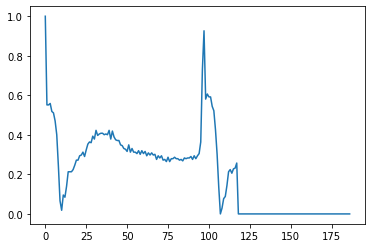

In [7]:
#! /usr/bin/enc python
# -*- coding: utf-8 -*-
# author: Jarvis Dong
# email: cauc1ronman@outlook.com

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt


lmdb_path = "/content/drive/My Drive/Research/Data/Train2"
test_lmdb_path = "/content/drive/My Drive/Research/Data/Test2"


# Resnet_ecg = resnet34()
# Resnet_ecg.to(device)
# Resnet_ecg = Explo_batch_net()
# Resnet_ecg.to(device)
Resnet_ecg = ResNet_ecg(**config)
Resnet_ecg.to(device)

# optimizer = optim.Adam(Resnet_ecg.parameters(),lr=1e-2,weight_decay=4e-5)
# optimizer = optim.Adam(Resnet_ecg.parameters(), lr=1e-2, weight_decay=1e-3)
optimizer = optim.SGD(Resnet_ecg.parameters(), lr=1e-3, momentum=0.9, weight_decay=4e-5) 

# lr decay policy 
# milestones = [60,120,160]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True) 
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones,gamma=0.1) # learning rate decay (cifar100 params)
loss_func = torch.nn.CrossEntropyLoss().to(device)


# warmup with pytorch_warmup pkg 
# import pytorch_warmup as warmup 
# warm

test_loss = np.zeros([num_epochs,1]) 

training = LmdbDataset(lmdb_path)
Train = DataLoader(training, batch_size=batch_size, shuffle=True, num_workers=0)
testing = LmdbDataset(test_lmdb_path)
Test = DataLoader(testing,batch_size=len(testing),shuffle=True,num_workers=0)

training_loss_record = np.zeros([num_epochs,1])
testing_loss_record = np.zeros([num_epochs,1]) 

for batch_idx,batch in enumerate(Train):
  input_x,input_y=tuple(t for t in batch)
  print(input_x.shape)
  print(input_y.shape)
  plt.plot(input_x[29])
  print(input_y)
  break

for batch_idx,batch in enumerate(Test):
  input_x,input_y=tuple(t for t in batch)
  print(input_x.shape)
  print(input_y.shape)  

print(len(Train.dataset))

# print(len(Test.dataset))

# input_y -= torch.ones(input_y.shape)  
# plt.plot(input_x[50].cpu().numpy(),'b-',label='original signal')

# detrending_signal = input_x[50].cpu().numpy()-\
# poly_fit_utils(input_y[50].cpu().numpy(),times,\
#                input_x[50].cpu().numpy())[0]

# plt.plot(detrending_signal,'r--',label='detrending signal')
# plt.grid()
# plt.legend()
# plt.show()
# print(input_y.cpu().numpy())
# input_y -= 1
# print("current order:", input_y[50])  

# plt.plot(input_x[50].cpu().numpy()/np.max(input_x[50].cpu().numpy()),'b-',label='original signal')
# plt.show() 

# plt.plot(input_x[50].cpu()/torch.max(input_x[50].cpu()),'r-',label='original signal')
# plt.show()

# print(input_x[0:10])
# print(input_x[0:10]/torch.max(input_x[0:10].cpu()))

# warmup trick 
# print("iter_per_epoch:",len(Train))
# warm = 1 # 10个epoch的warmup 
# warmup_scheduler = WarmUpLR(optimizer,len(Train)*warm) 

# Resnet_ecg.to(device)  
# Resnet_ecg.load_state_dict(torch.load("/content/drive/My Drive/Pytorch/Model_WorkFre/Work_order_predict_without_norm_1Res18_3.pt"))


In [8]:
import torch 
# 清除GPU内存 
torch.cuda.empty_cache()

print(Resnet_ecg)

ResNet_ecg(
  (0): Sequential(
    (0): Conv1d(1, 128, kernel_size=(31,), stride=(4,), padding=(15,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=15, stride=4, padding=5, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): ResidualBlock(
        (conv1): Conv1d(128, 128, kernel_size=(15,), stride=(4,), padding=(7,), bias=False)
        (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv1d(128, 128, kernel_size=(15,), stride=(1,), padding=(7,), bias=False)
        (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv1d(128, 128, kernel_size=(15,), stride=(4,), padding=(7,), bias=False)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

# Training

In [ ]:
#! /usr/bin/enc python
# -*- coding: utf-8 -*-
# author: Jarvis Dong
# email: cauc1ronman@outlook.com

best_acc = 0.0

# performance params 
for epoch in range(num_epochs):

  # if epoch >= warm:
    # scheduler.step(test_loss)

  # epoch = 0 
  loss_x = []
  loss_x2 = []

  # train 
  Resnet_ecg.train()
  train_loss = 0 

  for batch_idx,batch in enumerate(Train):

    # # ---------- Warmup stage ------------ 
    # if epoch < warm:
    #   warmup_scheduler.step()
    
    # if epoch < warm and batch_idx == 0: 
    #   print("ε=(´ο｀*)) Warmup_stage... ") 
    # # ---------------------------------------

    input_x,input_y = tuple(t.to(device) for t in batch)
    max = torch.max(input_x.cpu())
    input_x /= max
    # input_x = torch.reshape(input_x,(input_x.shape[0],8,256))
    input_x = torch.unsqueeze(input_x,1)
    # input_y -= 1 
    # input_x = input_x.type(torch.FloatTensor)
    # input_y = input_y.type(torch.FloatTensor)
    pred = Resnet_ecg(input_x.to(device))
    loss = loss_func(pred,input_y.type(torch.LongTensor).to(device))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # step += 1 
    loss_x.append(loss.item()) 
    train_loss += loss.item()

  training_loss_record[epoch] = train_loss/len(Train)
  print("epoch:{}, current training loss:{}".format(epoch,training_loss_record[epoch]))

  # releasing unnecessary memory in GPU 
  if torch.cuda.is_available():
    torch.cuda.empty_cache() 

  # ------------------ val ---------------------------------------- 
  # if epoch % test_every_epoch == 0:
    
  Resnet_ecg.eval()

  # test 
  test_loss = 0 
  correct = 0 
  precision,recall,f1,accuracy = [],[],[],[] 

  with torch.no_grad():
    for batch_idx,batch in enumerate(Test):
      input_x,input_y=tuple(t.to(device) for t in batch)
      max = torch.max(input_x.cpu())
      input_x /= max
      input_x = input_x.unsqueeze(1)
      # input_x = torch.reshape(input_x,(input_x.shape[0],8,256))
      # input_x = input_x.type(torch.FloatTensor)
      # input_y = input_y.type(torch.FloatTensor) 
      # input_y -= 1 
      pred = Resnet_ecg(input_x.to(device))
      loss = loss_func(pred,input_y.type(torch.LongTensor).to(device))
      test_loss += loss.item() 
      pred_label = pred.data.max(1)[1] # get the index of the max log-probability 
      correct += pred_label.cpu().eq(input_y.cpu()).sum() 

      # calculate P/R/F1/A metrics for batch
      for acc, metric in zip((precision, recall, f1, accuracy), 
            (precision_score, recall_score, f1_score, accuracy_score)):
        acc.append(
            calculate_metric(metric, input_y.cpu(), pred_label.cpu())
        )

  test_loss = test_loss / len(Test)
  
  testing_loss_record[epoch] = test_loss
  accu = 100.*correct/len(Test.dataset)

  print_scores(precision, recall, f1, accuracy, len(Test))
  print("epoch:",epoch,"---current_test_loss:",test_loss,"---accuracy:",accu.numpy(),"%")

  # model saving 
  if (epoch+1) % save_every_epoch == 0: 
    model_dir = '/content/drive/My Drive/Research/save_models/'
    model_name = 'ECG_predict_0.pt'
    torch.save(Resnet_ecg.state_dict(), model_dir+model_name)
    print("Saving complete!") 
  
  # save the best 
  if accu > best_acc: 
    best_acc = accu 
    model_dir = '/content/drive/My Drive/Research/save_models/'
    model_name = 'ECG_predict_best_0.pt'
    torch.save(Resnet_ecg.state_dict(), model_dir+model_name)
    print("Saving best model complete!") 
  
  scheduler.step(test_loss) 

print("="*50)
print("End...")

epoch:0, current training loss:[0.38336387]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	     precision: 0.2500
	        recall: 0.2384
	            F1: 0.2440
	      accuracy: 0.9535
epoch: 0 ---current_test_loss: 0.12290399521589279 ---accuracy: 95.35 %
Saving best model complete!
epoch:1, current training loss:[0.23157615]
	     precision: 0.2500
	        recall: 0.2377
	            F1: 0.2437
	      accuracy: 0.9510
epoch: 1 ---current_test_loss: 0.12590332329273224 ---accuracy: 95.1 %
